In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X_orig, y_orig = get_data("conv2d", base_dir, sample_rate=1.0)
X_orig.info()

df = pd.concat([X_orig, y_orig], axis=1)
df = df.query("time > 0").dropna()

34it [00:33,  1.57s/it]

< 0 found in file time.32.1024.0.pkl


44it [00:48,  1.14s/it]

< 0 found in file time.128.512.0.pkl


46it [00:50,  1.05s/it]

< 0 found in file time.128.1024.0.pkl


54it [00:58,  1.10it/s]

< 0 found in file time.512.128.0.pkl


56it [01:00,  1.07it/s]

< 0 found in file time.512.512.0.pkl


58it [01:02,  1.05it/s]

< 0 found in file time.512.1024.0.pkl


59it [01:04,  1.16s/it]

< 0 found in file time.512.1024.1.pkl


64it [01:06,  1.44it/s]

< 0 found in file time.1024.32.0.pkl


66it [01:09,  1.21it/s]

< 0 found in file time.1024.128.0.pkl


68it [01:11,  1.10it/s]

< 0 found in file time.1024.512.0.pkl


69it [01:13,  1.11s/it]

< 0 found in file time.1024.512.1.pkl


70it [01:13,  1.08it/s]

< 0 found in file time.1024.1024.0.pkl


71it [01:15,  1.15s/it]

< 0 found in file time.1024.1024.1.pkl


72it [01:15,  1.05s/it]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685125 entries, 0 to 685124
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             685125 non-null  int64  
 1   in_channels   685125 non-null  int64  
 2   iH            685125 non-null  int64  
 3   iW            685125 non-null  int64  
 4   out_channels  685125 non-null  int64  
 5   groups        685125 non-null  int64  
 6   kH            685125 non-null  int64  
 7   kW            685125 non-null  int64  
 8   stride        685125 non-null  int64  
 9   dilation      685125 non-null  int64  
 10  oH            685125 non-null  int64  
 11  oW            685125 non-null  int64  
 12  gflops        685125 non-null  float64
 13  dtype_16      685125 non-null  bool   
 14  dtype_32      685125 non-null  bool   
 15  dtype_b16     685125 non-null  bool   
 16  transposed_0  685125 non-null  bool   
 17  transposed_1  685125 non-null  bool   
dtypes: b

# Basic Fit For Evaluation

Seems like most of the loss comes from fp16/b16. Lots of overfitting—maybe in data?

In [15]:
def fit_tree(dtype: str | int):
    temp = df.query(f"dtype_{dtype}")
    X, y = temp.drop(["time"], axis=1), temp["time"]

    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
    X_cv = pd.concat([X_train, X_val])
    y_cv = pd.concat([y_train, y_val])

    tree_model = DecisionTreeRegressor(max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
    tree_model.fit(X_cv, y_cv)
    
    run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)
    

## Fp32

Train--------
Mean Squared Error: 8213.639425213216
MAPE: 0.17741047400146054
R-squared: 0.9883894289078278


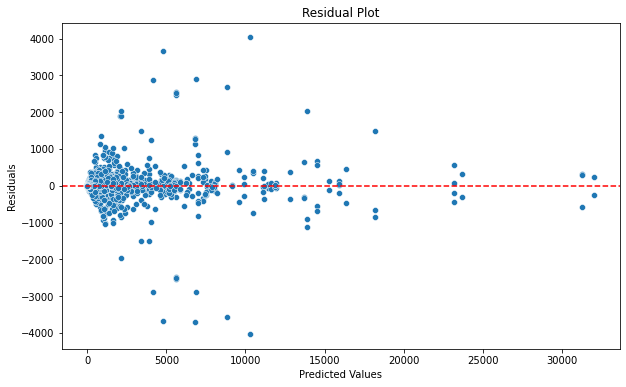

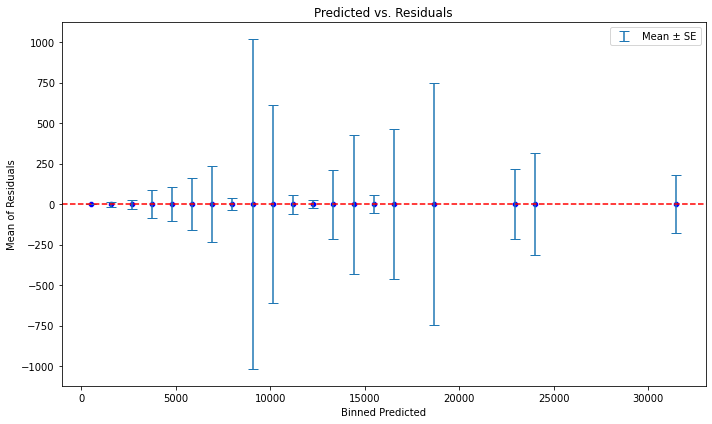

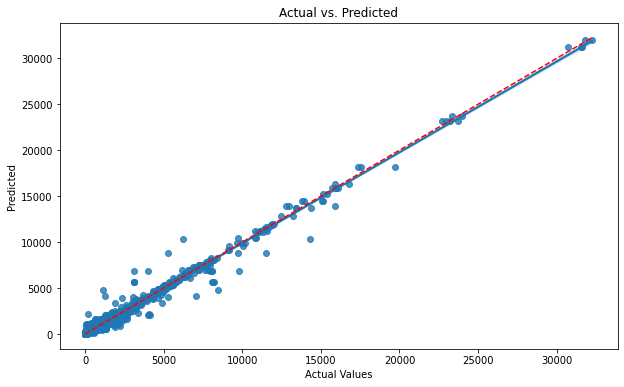

Val--------
Mean Squared Error: 19821.788637494123
MAPE: 0.4363008334603653
R-squared: 0.9651970602514705


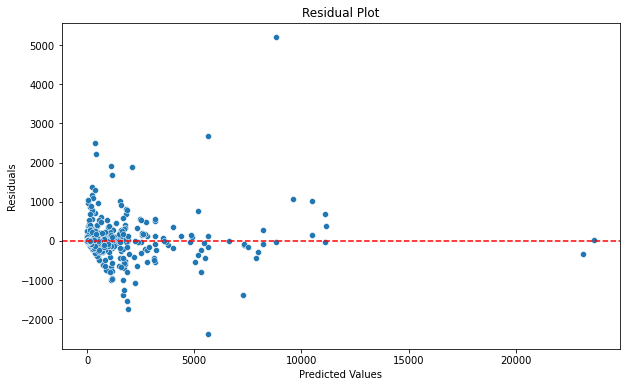

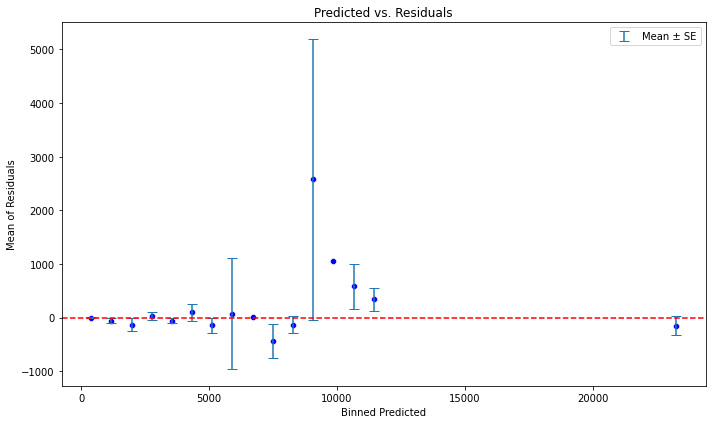

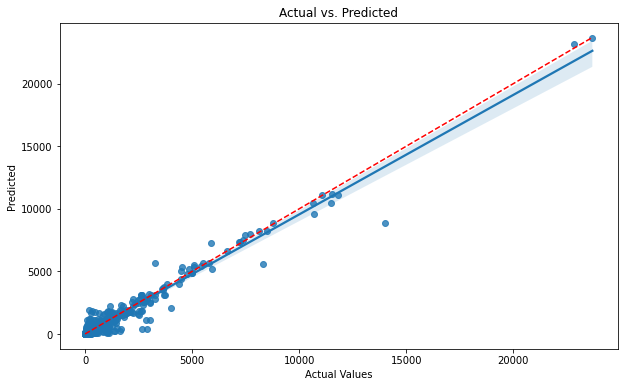

In [16]:
fit_tree(32)

## Fp16

Train--------
Mean Squared Error: 74428.56985510958
MAPE: 0.17187221400158842
R-squared: 0.9200755259979111


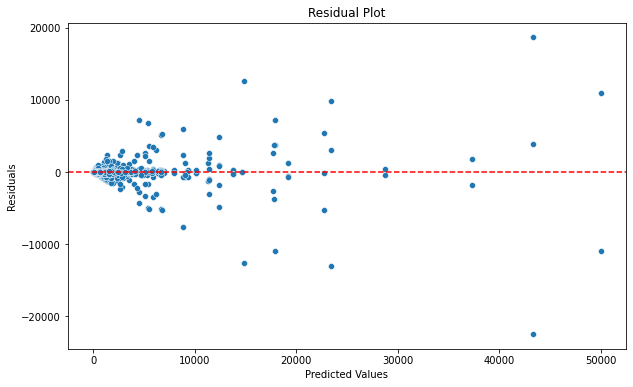

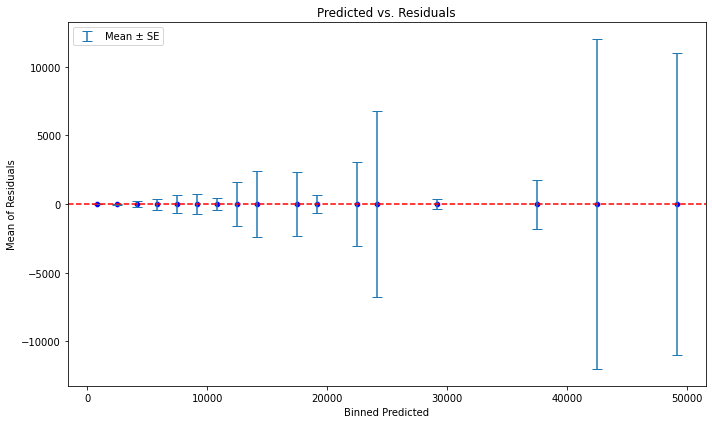

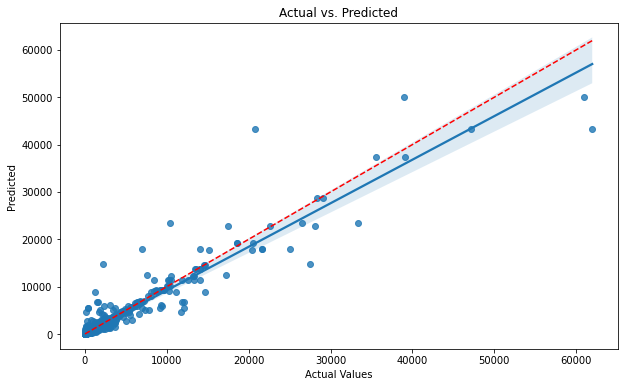

Val--------
Mean Squared Error: 296595.2470794498
MAPE: 0.38170154879234003
R-squared: 0.5382434893263168


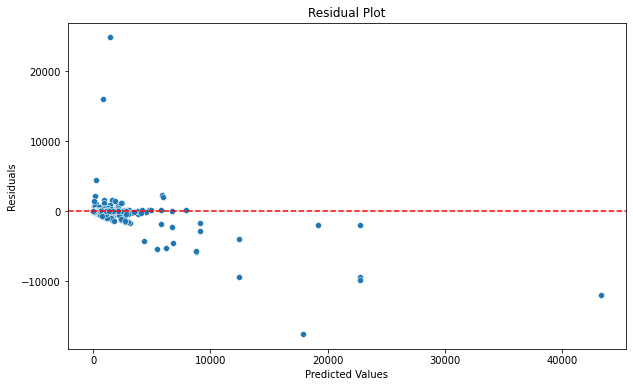

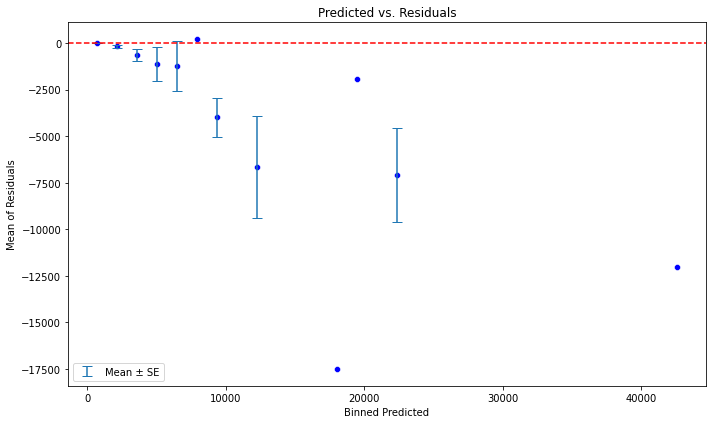

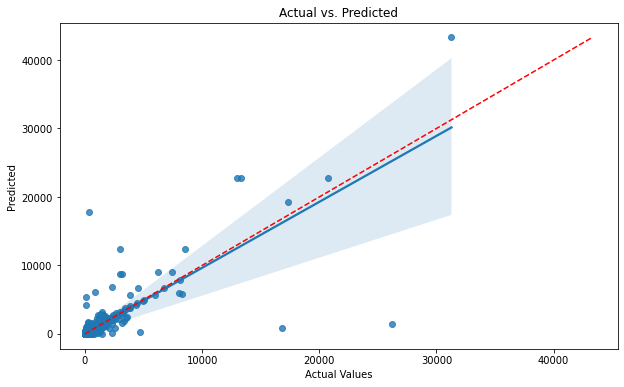

In [17]:
fit_tree(16)

## B16

Train--------
Mean Squared Error: 14186.569709778147
MAPE: 0.1479495751199909
R-squared: 0.9532327641258835


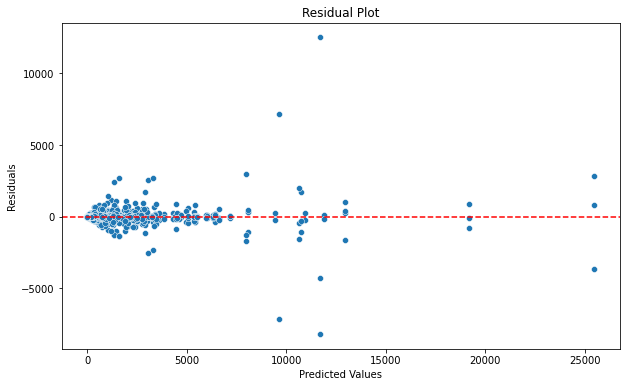

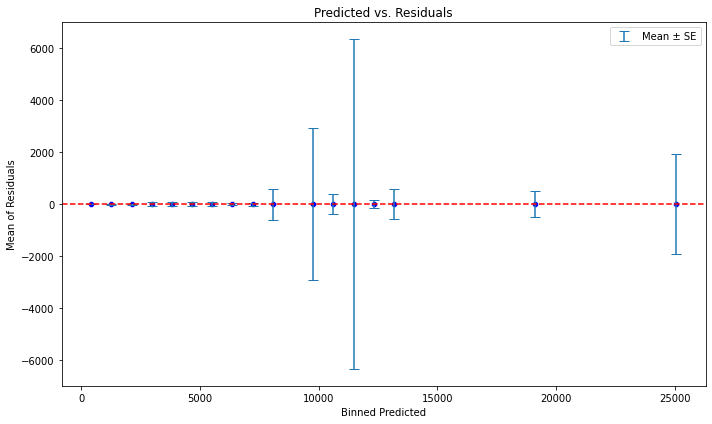

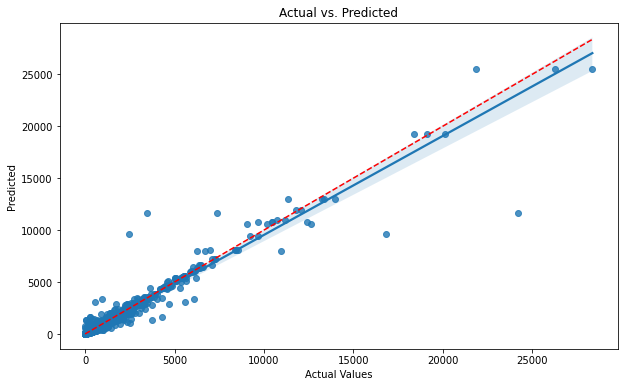

Val--------
Mean Squared Error: 84309.80984461123
MAPE: 0.34328518920841977
R-squared: 0.7664126665819992


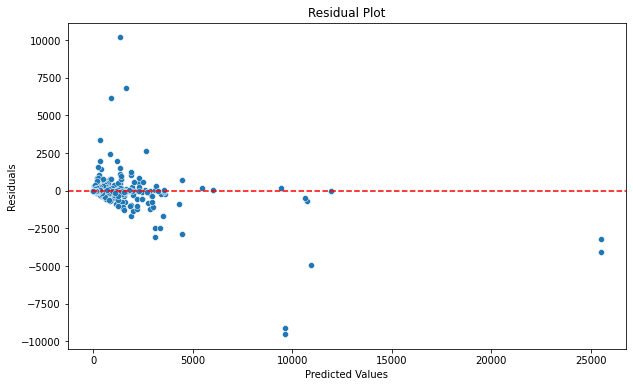

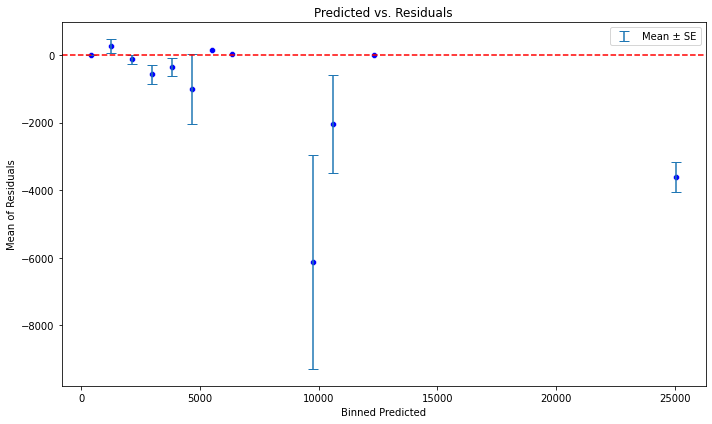

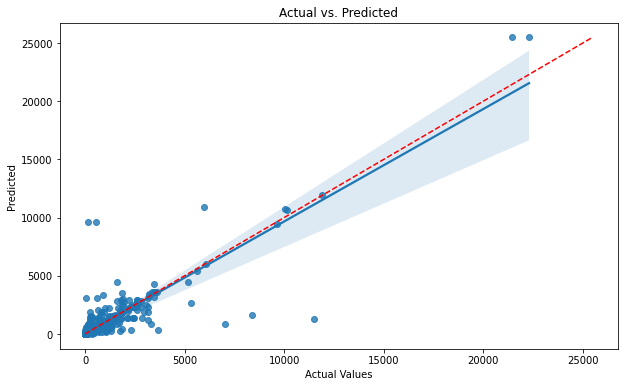

In [18]:
fit_tree("b16")

# Gridsearch tree

Doesn't alleviate the problem

In [36]:
def gridsearch_tree(dtype: str | int):
    temp = df.query(f"dtype_{dtype}")
    X, y = temp.drop(["time"], axis=1), temp["time"]

    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)

    X_cv = pd.concat([X_train, X_val])
    y_cv = pd.concat([y_train, y_val])
    
    tree_model = DecisionTreeRegressor(random_state=random_seed)

    param_grid = {
        "max_depth": [5, 10, 20, 30, 40],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [2, 5, 10],
        "max_features": [10, 20, 50, 100, 1.0, "sqrt"],
    }

    grid_search = GridSearchCV(
        estimator=tree_model,
        param_grid=param_grid,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        cv=10,
        # verbose=2,
        n_jobs=-1,
    )
    grid_search.fit(X_cv, y_cv)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R-squared found: ", grid_search.best_score_)

    best_tree_model = grid_search.best_estimator_
    best_tree_model
    
    best_tree_model.fit(X_cv, y_cv)

    run_val_pipeline(best_tree_model, X_cv, X_test, y_cv, y_test, bins=30)
    


## Fp32

Best parameters found:  {'max_depth': 40, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best R-squared found:  -8553.85670961112
Train--------
Mean Squared Error: 1891.4387637959107
MAPE: 0.05202897521162756
R-squared: 0.9971111248431972


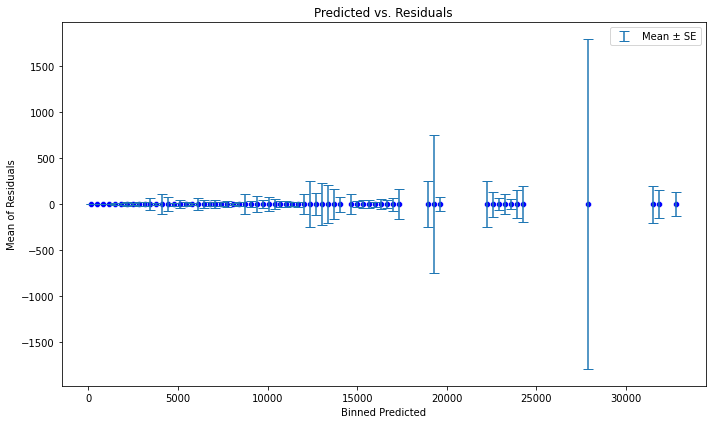

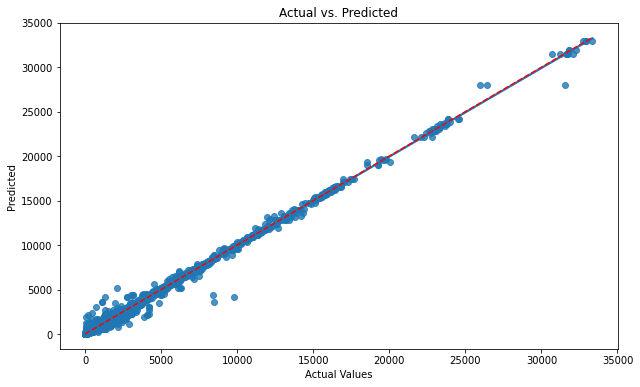

Val--------
Mean Squared Error: 9896.029372975303
MAPE: 0.14528892038338484
R-squared: 0.9860009341654336


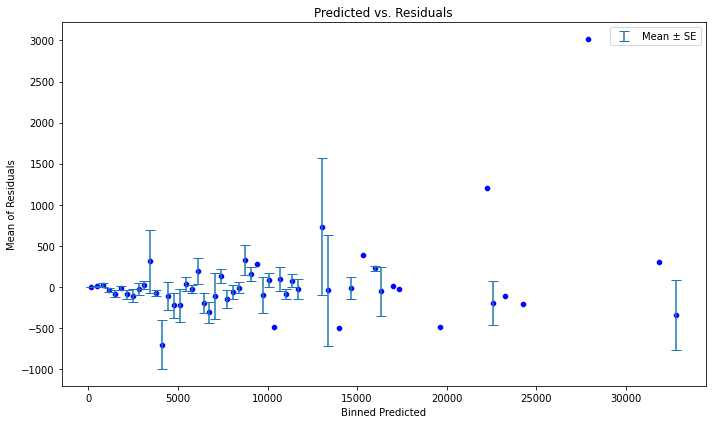

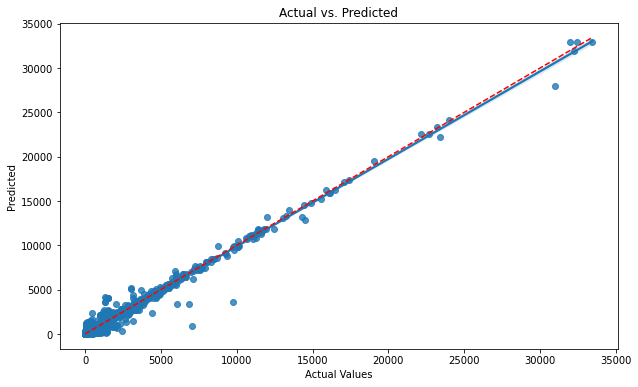

In [37]:
gridsearch_tree(32)

## Fp16

Best parameters found:  {'max_depth': 30, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best R-squared found:  -84356.8434689467
Train--------
Mean Squared Error: 11233.215405120223
MAPE: 0.04771651351358296
R-squared: 0.981258172365397


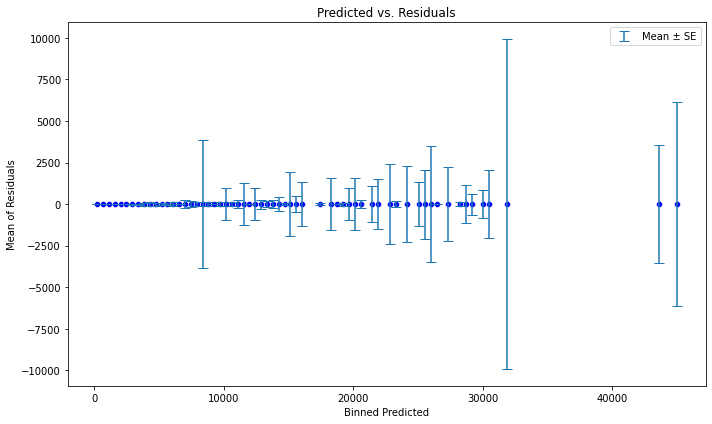

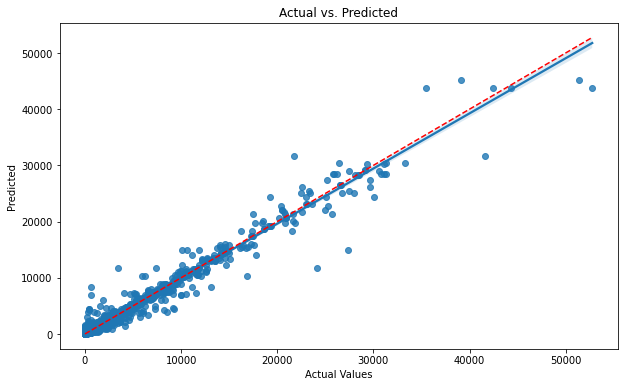

Val--------
Mean Squared Error: 184249.52512011514
MAPE: 0.135953316840415
R-squared: 0.782127078873657


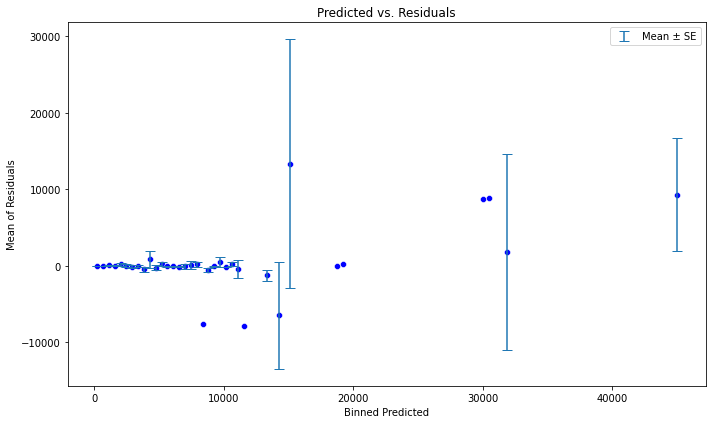

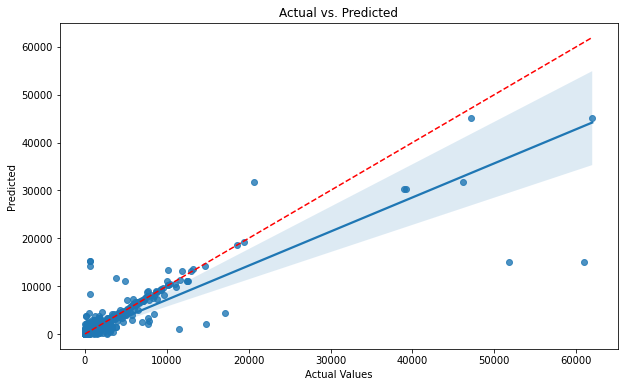

In [38]:
gridsearch_tree(16)

## Fp b16

Best parameters found:  {'max_depth': 30, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best R-squared found:  -13490.940981567906
Train--------
Mean Squared Error: 3067.521832396569
MAPE: 0.03885780940239011
R-squared: 0.9881879257506294


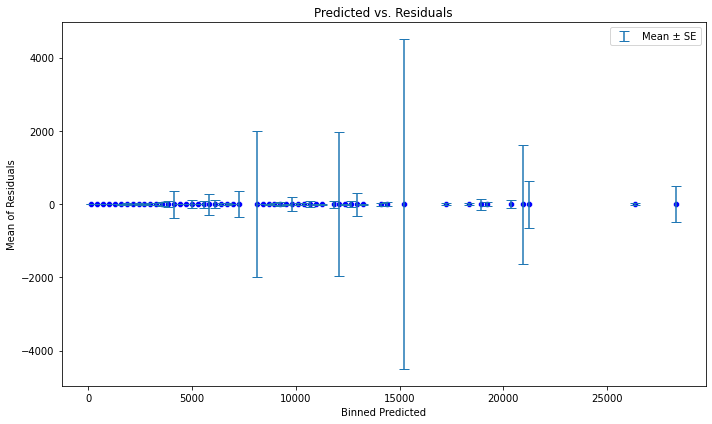

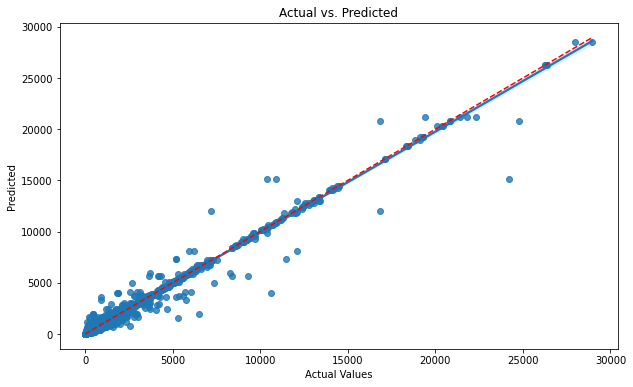

Val--------
Mean Squared Error: 9949.924119901261
MAPE: 0.10746478376415493
R-squared: 0.962336637606378


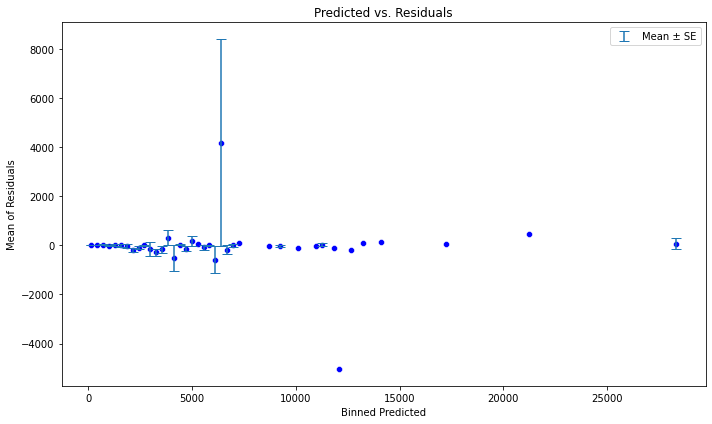

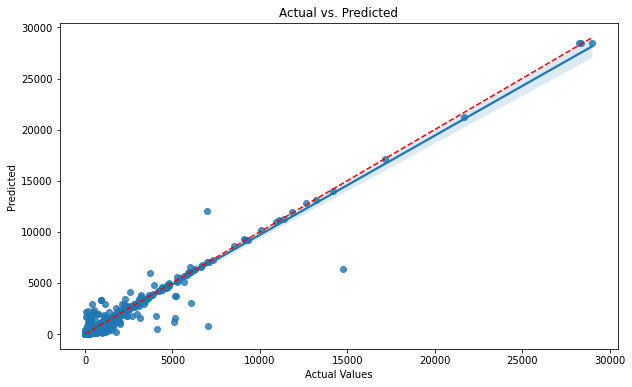

In [39]:
gridsearch_tree("b16")

# Random Forest Gridsearch CV

In [5]:
def randomizedsearch_forest(dtype: str | int, n_iter=50):
    temp = df.query(f"dtype_{dtype}")
    X, y = temp.drop(["time"], axis=1), temp["time"]

    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)

    X_cv = pd.concat([X_train, X_val])
    y_cv = pd.concat([y_train, y_val])

    tree_model = RandomForestRegressor(random_state=random_seed)

    param_dist = {
        "max_depth": [5, 10, 30, 50, 100],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [2, 5, 10],
        "max_features": [10, 20, 50, 100, 1.0, "sqrt"],
        "n_estimators": [10, 50, 100],
    }

    randomized_search = RandomizedSearchCV(
        estimator=tree_model,
        param_distributions=param_dist,
        n_iter=n_iter,  # Number of iterations to perform
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        cv=5,
        random_state=random_seed,
        n_jobs=3,
    )

    randomized_search.fit(X_cv, y_cv)
    print("Best parameters found: ", randomized_search.best_params_)
    print("Best R-squared found: ", randomized_search.best_score_)
    
    best_tree_model = randomized_search.best_estimator_
    
    best_tree_model.fit(X_cv, y_cv)

    run_val_pipeline(best_tree_model, X_cv, X_test, y_cv, y_test, bins=30)

## Fp32

In [6]:
randomizedsearch_forest("32")

/opt/miniconda3/envs/research/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

## Fp16

In [ ]:
randomizedsearch_forest("16")

## Fpb16

In [ ]:
randomizedsearch_forest("b16")